In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow import keras

import scipy.stats as stats

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.2f}".format

sns.set_theme(style="darkgrid")
cm = px.colors.sequential.Bluered

warnings.filterwarnings("ignore")

In [3]:
# import sys

# sys.path.insert(1, '/kaggle/input/mymodules')

import my_module

In [4]:
# PATH = '/kaggle/input/house-prices-advanced-regression-techniques/'
PATH = ""

train = pd.read_csv(f"{PATH}train.csv")
train.drop(["Id"], axis=1, inplace=True)

test = pd.read_csv(f"{PATH}test.csv")
test_ID = test["Id"]

test.drop(["Id"], axis=1, inplace=True)

df = pd.concat([train, test], ignore_index=True)

df.tail()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
2914         160       RM        21.00     1936   Pave   NaN      Reg   
2915         160       RM        21.00     1894   Pave   NaN      Reg   
2916          20       RL       160.00    20000   Pave   NaN      Reg   
2917          85       RL        62.00    10441   Pave   NaN      Reg   
2918          60       RL        74.00     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
2914         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
2915         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
2916         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
2917         Lvl    AllPub    Inside  ...        0    NaN  MnPrv        Shed   
2918         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
2914       0      6    2006        WD         Normal        NaN  
2915       0      4    2006        WD        Abnorml        NaN  
2916       0      9    2006        WD        Abnorml        NaN  
2917     700      7    2006        WD         Normal        NaN  
2918       0     11    2006        WD         Normal        NaN  

[5 rows x 80 columns]

<a id='1'> </a>

# 1. EDA


Let's delete all columns with a lot of nan values


In [5]:
df = my_module.delete_nan_column(df, 0.25)

In [6]:
df["Train_test"] = df["SalePrice"].isnull().apply(lambda x: "Test" if x else "Train")

<a id='1.1'> </a>

## 1.1 Numeric columns


In [7]:
px.imshow(df.corr(), color_continuous_scale=cm, width=1000, height=1000)

First of all, I'm going to work with the features which are highly correlated with SalePrice.

Some of these features are correlated with each other, so I'm going to keep one of them and drop the other. For instance:

- YearBuilt and GarageYrBlt
- GarageArea and GarageCars


In [8]:
numeric_features = my_module.get_type_features(df, ["int64", "float64"])

df_corr_sorted = (
    df[numeric_features].corr().sort_values(by=["SalePrice"])[["SalePrice"]].T
)

px.imshow(df_corr_sorted, color_continuous_scale=cm)

Let's examine ditributions and try to find obvious outliers


In [9]:
features = my_module.get_corr_features(df[numeric_features].corr()["SalePrice"], 0.5)
features

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea',
 'SalePrice']

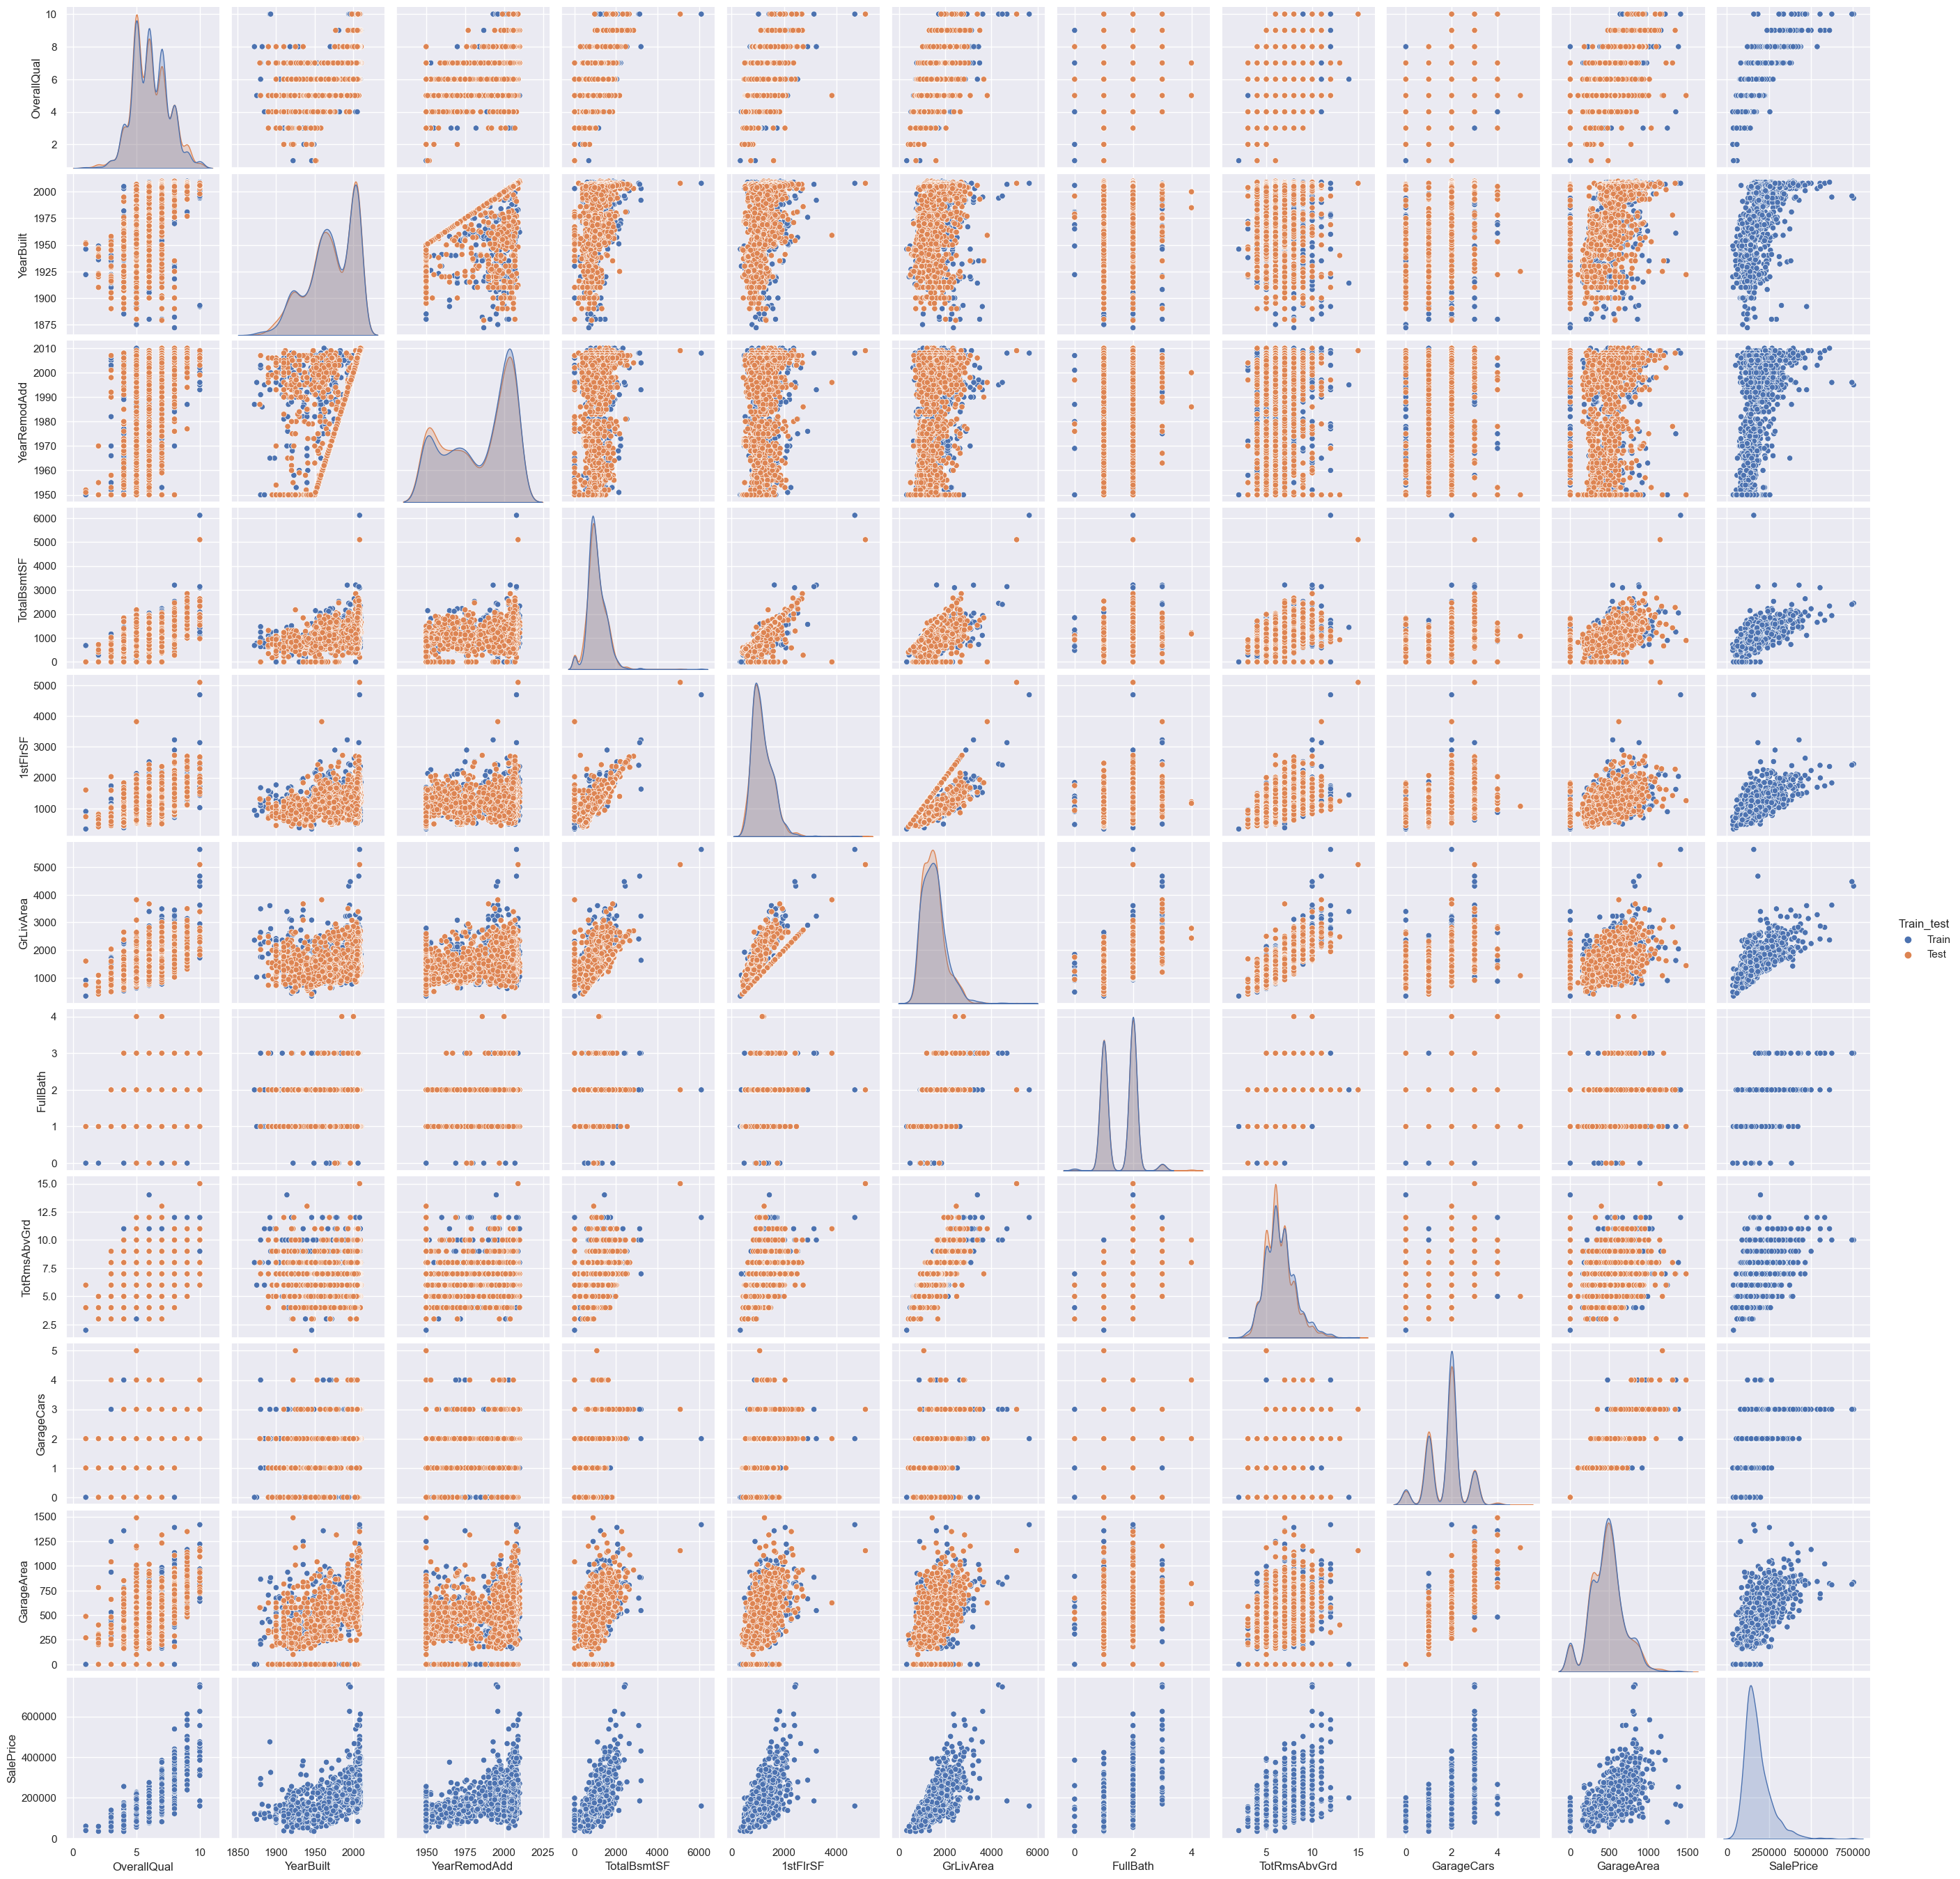

In [10]:
sns.pairplot(df[features + ["Train_test"]], diag_kind="kde", hue="Train_test")

There is a significant outlier in the top-right corner. What else is important, that these features are skewed, so I'm going to transform it later to make it more normal.


In [11]:
df[df["1stFlrSF"] > 4500][features]

OverallQual  YearBuilt  YearRemodAdd  TotalBsmtSF  1stFlrSF  GrLivArea  \
1298           10       2008          2008      6110.00      4692       5642   
2549           10       2008          2009      5095.00      5095       5095   

      FullBath  TotRmsAbvGrd  GarageCars  GarageArea  SalePrice  
1298         2            12        2.00     1418.00  160000.00  
2549         2            15        3.00     1154.00        NaN

1298 is the one. All positive correlated features are quite high, but the price is relatively low. I'll just delete it.


In [12]:
df.drop([1298], inplace=True)

<a></a>

### SalePrice


In [13]:
px.histogram(df, x="SalePrice").show()

In [14]:
df.loc[df["SalePrice"] > 480000, "SalePrice"] = 480000

In [15]:
px.histogram(df, x="SalePrice")

<a> </a>

### YearBuilt/YearRemodAdd


I combined YearBuilt and YearRemodAdd in a column


In [16]:
df["YearBuilt/Remod"] = df["YearBuilt"].copy()
df.loc[df["YearBuilt"] > 1950, "YearBuilt/Remod"] = df.loc[
    df["YearBuilt"] > 1950, "YearRemodAdd"
]

In [17]:
px.histogram(df, x="YearBuilt/Remod", color="Train_test")

In [18]:
df.loc[df["YearBuilt/Remod"] < 1895, "YearBuilt/Remod"] = 1895
df.drop(["YearBuilt", "YearRemodAdd"], axis=1, inplace=True)
features.remove("YearBuilt")
features.remove("YearRemodAdd")
features.insert(0, "YearBuilt/Remod")

<a> </a>

### GarageArea/GarageCars


In [19]:
df[["GarageArea", "GarageCars"]].corr()

GarageArea  GarageCars
GarageArea        1.00        0.89
GarageCars        0.89        1.00

GarageArea looks more informative and balanced, so I delete GarageCars


In [20]:
df.drop(["GarageCars"], axis=1, inplace=True)
features.remove("GarageCars")

In [21]:
px.histogram(df, x="GarageArea", color="Train_test")

Some clipping


In [22]:
df.loc[df["GarageArea"] > 950, "GarageArea"] = 950

<a> </a>

### TotalBsmtSF


In [23]:
px.histogram(df, x="TotalBsmtSF", color="Train_test")

In [24]:
df.loc[df["TotalBsmtSF"] > 2250, "TotalBsmtSF"] = 2250

<a id='1.1.2'> </a>

### GrLivArea


In [25]:
px.histogram(df, x="GrLivArea", color="Train_test")

In [26]:
df.loc[df["GrLivArea"] > 2800, "GrLivArea"] = 2800

<a> </a>

### 1stFlrSF


In [27]:
px.histogram(df, x="1stFlrSF", color="Train_test")

In [28]:
df.loc[df["1stFlrSF"] > 2500, "1stFlrSF"] = 2500

<a> </a>

### FullBath


In [29]:
px.histogram(df, x="FullBath", color="Train_test")

In [30]:
df.loc[df["FullBath"] == 0, "FullBath"] = 1
df.loc[df["FullBath"] == 4, "FullBath"] = 3
px.histogram(df, x="FullBath", color="Train_test")

<a> </a>

### TotRmsAbvGrd


In [31]:
px.histogram(df, x="TotRmsAbvGrd", color="Train_test")

In [32]:
df.loc[df["TotRmsAbvGrd"] > 12, "TotrmsAbvGrd"] = 12

<a id="2"></a>

# 2. Preprocessing


In [33]:
features

['YearBuilt/Remod',
 'OverallQual',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageArea',
 'SalePrice']

Imput median values in the numeric columns


In [34]:
df_final = df[features].copy(deep=True)

In [35]:
for col in features[:-1]:
    imp = SimpleImputer(missing_values=np.nan, strategy="median")
    df_final[[col]] = imp.fit_transform(df_final[[col]])

<a> </a>

### Transformation of data


In [36]:
power = preprocessing.PowerTransformer()
for_tranfrom = ["TotalBsmtSF", "1stFlrSF", "GrLivArea", "GarageArea"]
df_final[for_tranfrom] = power.fit_transform(df_final[for_tranfrom])
df_final.head()

YearBuilt/Remod  OverallQual  TotalBsmtSF  1stFlrSF  GrLivArea  FullBath  \
0          2003.00         7.00        -0.41     -0.78       0.57      2.00   
1          1976.00         6.00         0.54      0.43      -0.39      2.00   
2          2002.00         7.00        -0.26     -0.56       0.71      2.00   
3          1915.00         7.00        -0.66     -0.42       0.58      1.00   
4          2000.00         8.00         0.27      0.12       1.39      2.00   

   TotRmsAbvGrd  GarageArea  SalePrice  
0          8.00        0.40  208500.00  
1          6.00       -0.00  181500.00  
2          6.00        0.67  223500.00  
3          7.00        0.82  140000.00  
4          9.00        1.65  250000.00

Scalling


In [37]:
scaler = preprocessing.StandardScaler()
df_final[df_final.columns[:-1]] = scaler.fit_transform(df_final.iloc[:, :-1])
df_final.head()

YearBuilt/Remod  OverallQual  TotalBsmtSF  1stFlrSF  GrLivArea  FullBath  \
0             0.92         0.65        -0.41     -0.78       0.57      0.80   
1             0.05        -0.06         0.54      0.43      -0.39      0.80   
2             0.89         0.65        -0.26     -0.56       0.71      0.80   
3            -1.92         0.65        -0.66     -0.42       0.58     -1.06   
4             0.83         1.36         0.27      0.12       1.39      0.80   

   TotRmsAbvGrd  GarageArea  SalePrice  
0          0.99        0.40  208500.00  
1         -0.29       -0.00  181500.00  
2         -0.29        0.67  223500.00  
3          0.35        0.82  140000.00  
4          1.63        1.65  250000.00

Final view


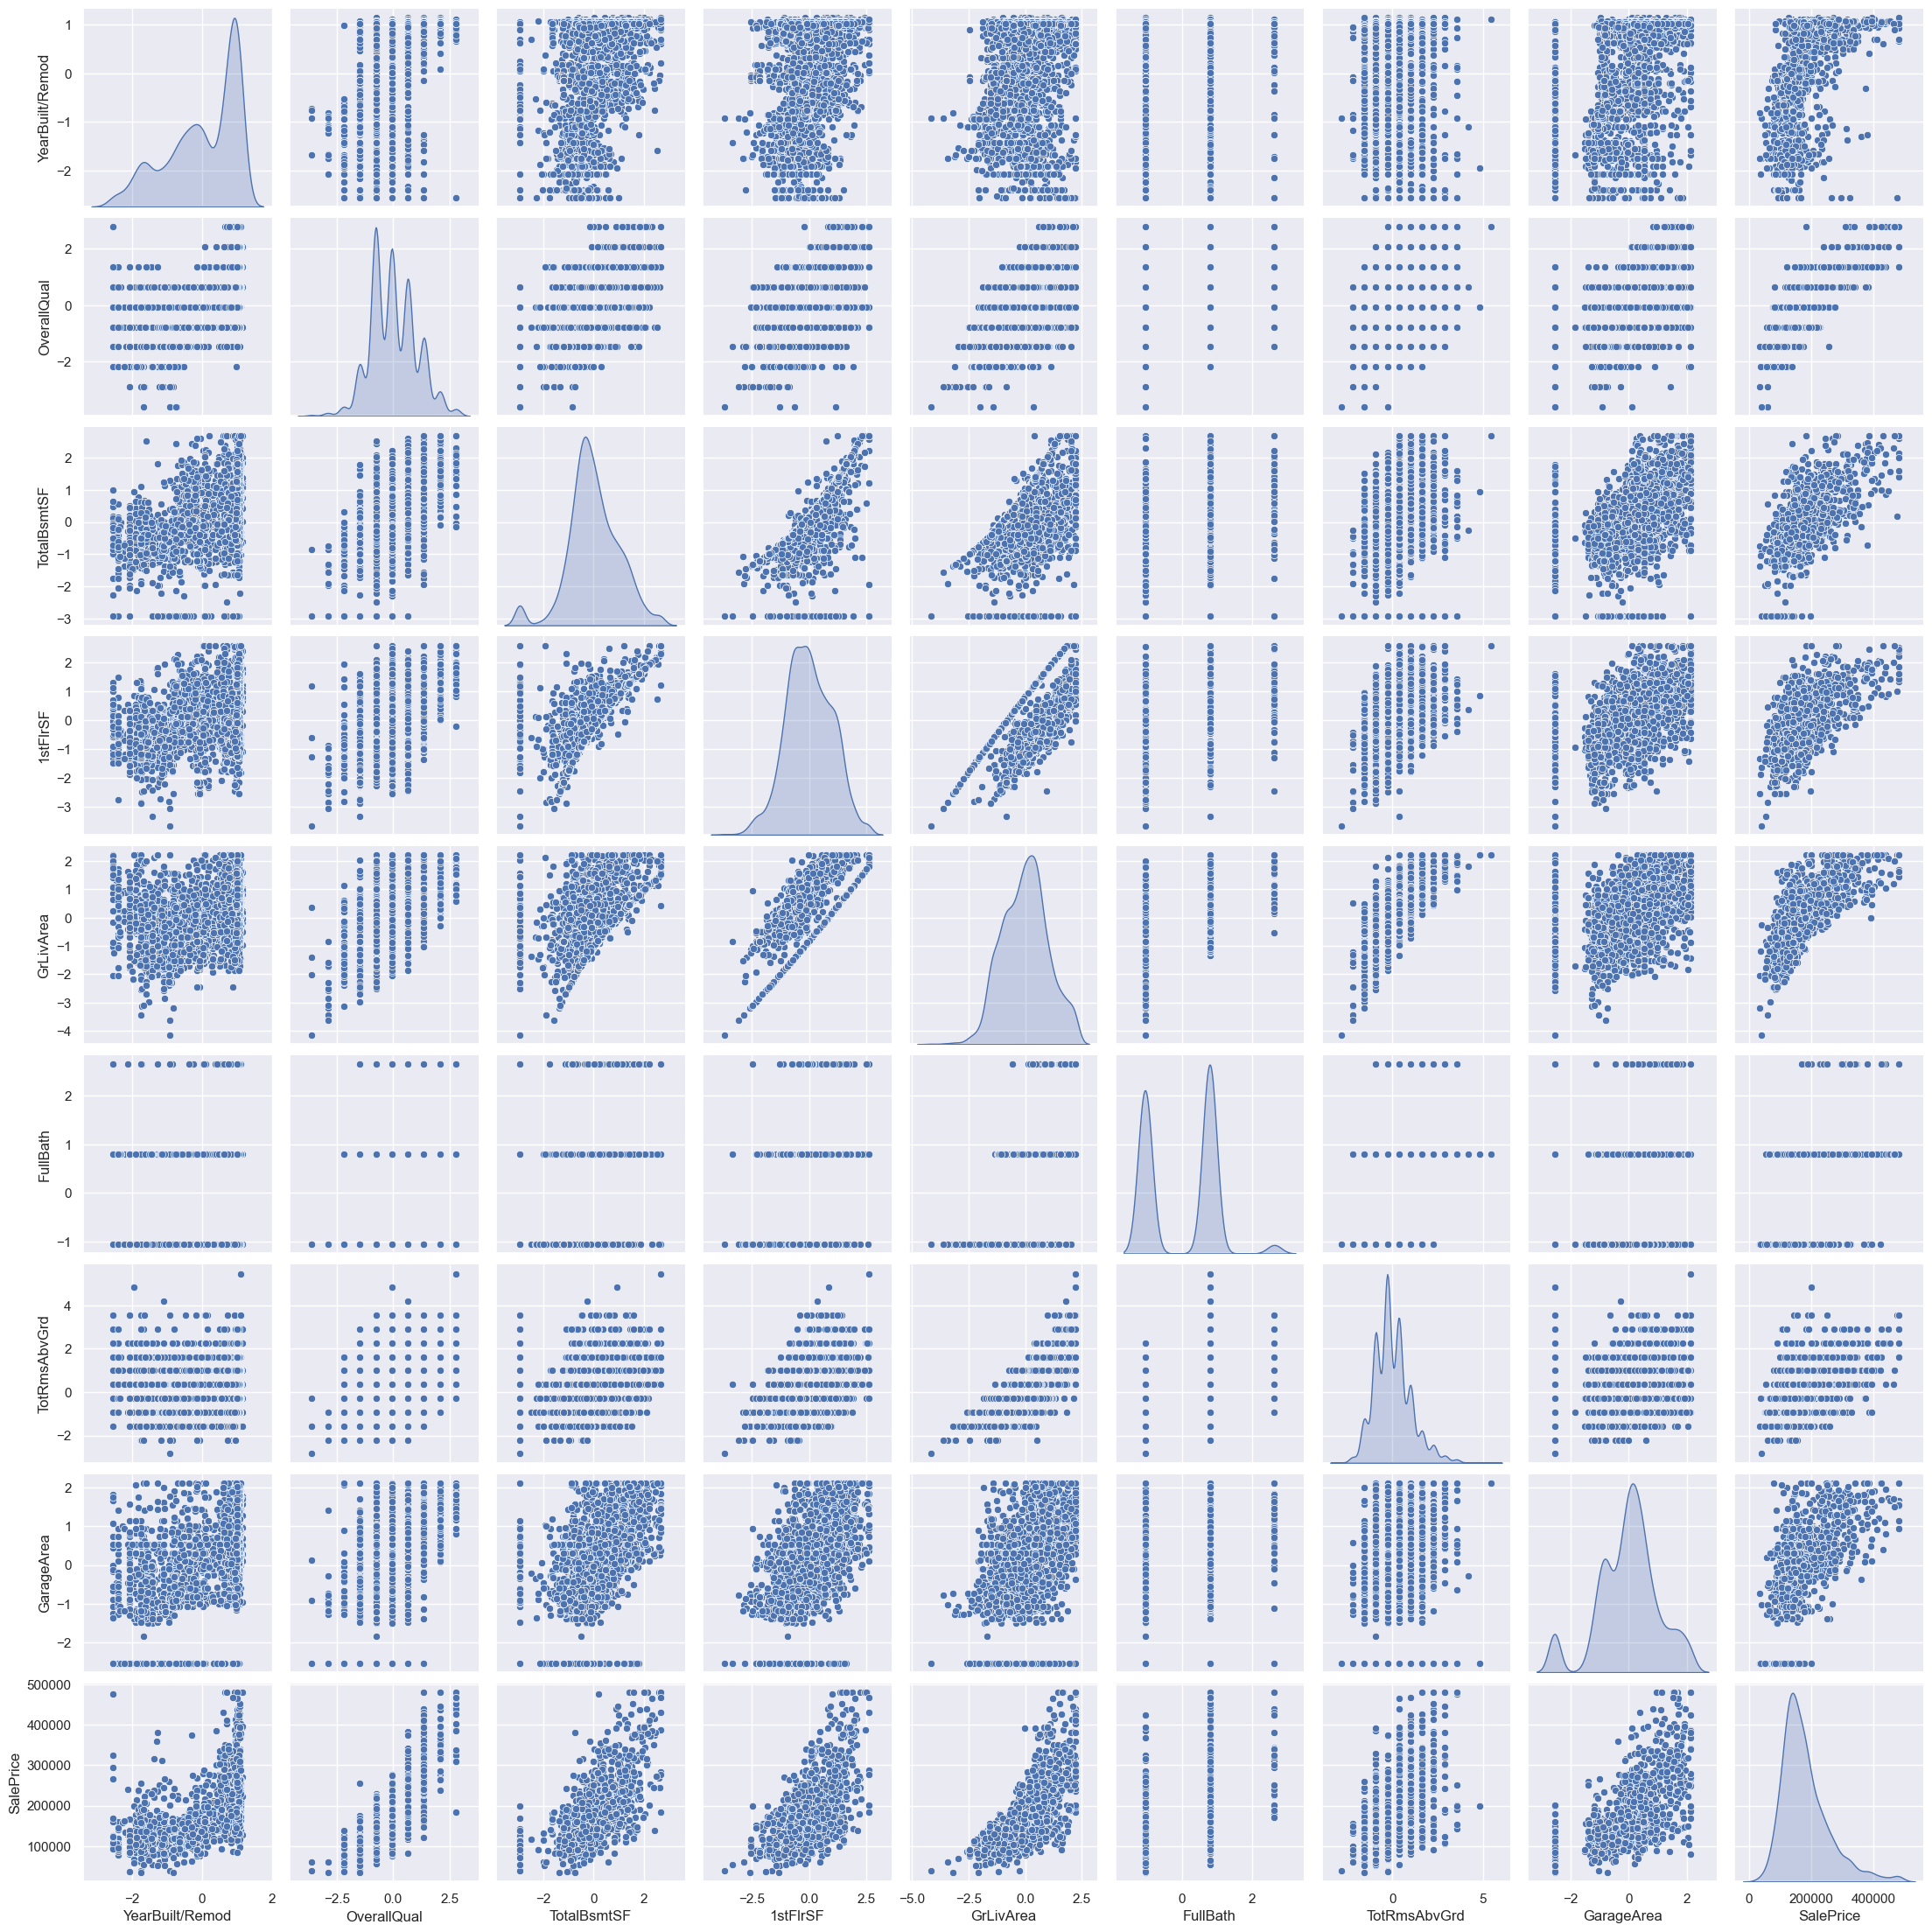

In [38]:
sns.pairplot(df_final, diag_kind="kde")

<a id="3"></a>

# 3. Model development


<a id='3.1'> </a>

## 3.1 Baseline


In [39]:
df_final.columns

Index(['YearBuilt/Remod', 'OverallQual', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageArea', 'SalePrice'],
      dtype='object')

In [40]:
for_prediction = [
    "OverallQual",
    "TotalBsmtSF",
    "GrLivArea",
    "GarageArea",
    "1stFlrSF",
    "YearBuilt/Remod",
    "FullBath",
    "SalePrice",
]

df_features = df_final[for_prediction]

In [41]:
rng = 0
x = df_features[~df_features["SalePrice"].isna()][df_features.columns[:-1]]
y = df_features[~df_features["SalePrice"].isna()]["SalePrice"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=rng
)

In [42]:
my_module.check_distribution(x_train, x_test)

OverallQual  TotalBsmtSF  GrLivArea  GarageArea  1stFlrSF  YearBuilt/Remod  \
0         True         True       True        True      True             True   

   FullBath  
0      True

As we predict a continues value, we can use a mean value as a baseline


In [43]:
mean_price = np.full(len(x), np.mean(y))
my_module.print_evaluate_regression(mean_price, y)

MSE: 5692225017.019124
RMSLE: 0.1623656493871091
______


<a id='3.2'></a>

## 3.2 Simple NN model


In [44]:
x_train.head()

OverallQual  TotalBsmtSF  GrLivArea  GarageArea  1stFlrSF  \
92         -0.77        -0.37      -1.21       -0.13     -0.41   
838        -0.77         0.16      -0.81       -0.51     -0.00   
360        -0.06        -0.34      -1.37        0.04     -0.59   
665         1.36         0.86       0.97        0.20      0.88   
40         -0.06         0.14      -0.24       -0.09      0.58   

     YearBuilt/Remod  FullBath  
92             -1.72     -1.06  
838             1.02     -1.06  
360             0.12     -1.06  
665             0.83      0.80  
40             -0.30      0.80

Final training loss: 903189568.0
Final Validation loss: 647604224.0
10/10 [==============================] - 0s 1ms/step
MSE: 705412673.741059
RMSLE: 0.02273772271696563
______


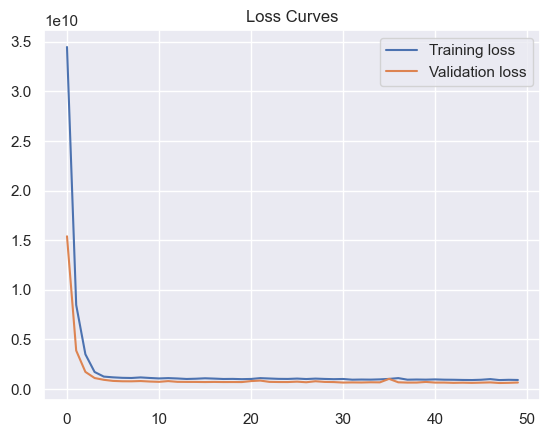

In [45]:
learning_rate = 0.5
epochs = 50
batch_size = 50

model = None

# Define model
model = keras.Sequential()
model.add(
    keras.layers.Dense(
        units=x_train.shape[1],
        activation="relu",
        input_dim=x_train.shape[1],
        kernel_regularizer=tf.keras.regularizers.l2(l2=0.01),
    ),
)
model.add(
    keras.layers.Dense(
        units=x_train.shape[1],
        activation="relu",
        input_dim=x_train.shape[1],
        kernel_regularizer=tf.keras.regularizers.l2(l2=0.01),
    )
)

model.add(keras.layers.Dense(units=1, activation="linear"))
# Specify the optimizer using the TF API to specify the learning rate
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss="mse",
)

# Train the model
trainHistory = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0,
)
# Plot
my_module.showRegressionResults(trainHistory)

my_module.print_evaluate_regression(model.predict(x_test), y_test)

In [46]:
x_sub = df_final.loc[df["SalePrice"].isna()][for_prediction[:-1]]
pred = model.predict(x_sub, batch_size=batch_size).flatten()

sub = pd.DataFrame({"Id": test_ID, "SalePrice": pred})
sub.to_csv("submission.csv", index=False)

30/30 [==============================] - 0s 1000us/step
